# Calculating particle ranging in filtration stacks

Note: because of how ReadTheDocs works, this notebook is pre-executed

In [1]:
import matplotlib.pyplot as plt

from cr39py.core.units import u
from cr39py.filtration.srim import SRIMData
from cr39py import Layer, Stack

CR-39 is only sensitive to charged particles within a certain energy range (approximately 1-4 MeV). So, CR-39 detectors are often fielded with filter materials in front of the CR-39 to range the particles down to the appropriate energy range. Choosing the materials and thicknesses of these filters is a crucial part of designing a CR-39 detector pack. This notebook will show how the `Layer` and `Stack` objects in cr39py make use of data from [SRIM](http://www.srim.org/) to calculate charged particle ranging in materials.

[SRIM](http://www.srim.org/) calculates stopping power curves for various incident particles and materials. A set of these output files commonly relevant to CR-39 experiments are bundeled with `cr39py` in the `cr39py/data/srim` folder, and new files can be added to that directory as needed. 

The `SRIMData`` class can be used to load these SRIM output files. The plot below shows the stopping power and projected range curves for protons in Aluminum.

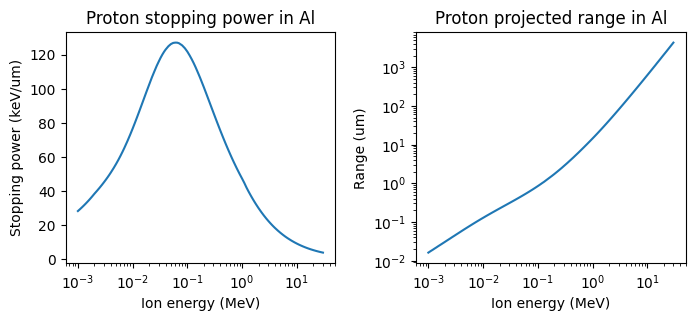

In [2]:
particle, material = 'Proton', 'Al'
srim = SRIMData.from_strings("Proton", "Al")

fig, axarr = plt.subplots(ncols=2, figsize=(8,3))
fig.subplots_adjust(wspace=0.3)

ax = axarr[0]
ax.set_title(f"{particle} stopping power in {material}")
ax.set_xlabel("Ion energy (MeV)")
ax.set_ylabel("Stopping power (keV/um)")
ax.set_xscale('log')
ax.plot(srim.ion_energy*1e-6, srim.dEdx_total)

ax = axarr[1]
ax.set_title(f"{particle} projected range in {material}")
ax.set_xlabel("Ion energy (MeV)")
ax.set_ylabel("Range (um)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(srim.ion_energy*1e-6, srim.projected_range*1e6);

The rapid increase of stopping power near 100 keV is responsible for the [Bragg peak](https://en.wikipedia.org/wiki/Bragg_peak).

Since the stopping power $dE/dx$ is a function of the particle energy, it will change as the particle travels through the material, loosing energy. To calculate the energy lost through the material, we therefore need to integrate

$\Delta E = \int_0^t \frac{dE(x)}{dx} dx$

where $t$ is the thickness of the material. If the particle energy changes significantly while in the material and we want to perform this integral numerically, we must choose a small enough $dx$ that the change in energy across it is negligible. In practice, for the materials and MeV energies encountered in most CR-39 experiments, around 1 um steps generally works.

## Layers

The `cr39py.filtration.stack.Layer` class internally uses this SRIM data to calculate the energy that a particle looses when scattering in a material. `Layer` objects are initialized using a string to describe the layer.

In [3]:
l = Layer.from_string('300 um Ta')

Eout = l.range_down("Proton", 14.7*u.MeV)
dE = l.ranging_energy_loss("Proton", 14.7*u.MeV)
print(f"The energy of the proton after the layer will be {Eout.m_as(u.MeV):.2f} MeV, depositing {dE.m_as(u.MeV):.2f} MeV in the layer")


The energy of the proton after the layer will be 5.47 MeV, depositing 9.23 MeV in the layer


Sometimes we know the energy of a particle on our detector, and want to know what the energy was before the particle passed through the filtration in front of the detector. In this case, we want to reverse the ranging calculation.

In [4]:
Ein = l.reverse_ranging("Proton", Eout)
print(f"The initial energy of the particle was {Ein.m_as(u.MeV):.1f} MeV")

The initial energy of the particle was 14.7 MeV


`Layer` performs the numerical integration in steps of `dx`, which is set to 1 um by default but which can be overridden with a keyword argument to any of the ranging methods. At each step of the numerical integration, the method also calculates the percent error in the stopping power due to the layer thickness:

$\frac{\lvert S(E-dE) - S(E) \rvert}{S(E)}$

And an exception is raised if this value exceeds a threshold (currently 5%.)

If we run the same code as above but manually set `dx` to be smaller, we should get a slightly more accurate result.

In [5]:
l = Layer.from_string('300 um Ta')
Eout = l.range_down("Proton", 14.7*u.MeV, dx=0.1*u.um)
print(f"The energy of the proton after the layer will be {Eout.m_as(u.MeV):.2f} MeV.")

The energy of the proton after the layer will be 5.45 MeV.


## Stacks

Frequently, more than one layer of filter material is positioned in front of a CR-39 detector. For example, a common detector stack for proton radiography is 

- 15 um Ta
- CR-39 for D-D protons (1500 um thick)
- 150 um Al
- CR-39 for D3He protons (1500 um thick)

The `Stack` object in `cr39py` has similar functionality to the `Layer` object, but performs these calculations on the entire stack of filters at once. Stacks can be initialized with a list of Layers, or by a comma-separated list of strings that each define a valid Layer.

In [6]:
s = Stack.from_string('15 um Ta, 1.5 mm CR-39, 150 um Al')

Eout = s.range_down("Proton", 14.7*u.MeV)
print(f"The energy on the front face of the second piece of CR-39 will be {Eout.m_as(u.MeV):.2} MeV")

The energy on the front face of the second piece of CR-39 will be 2.8 MeV
